# Αυτοκωδικοποιητές

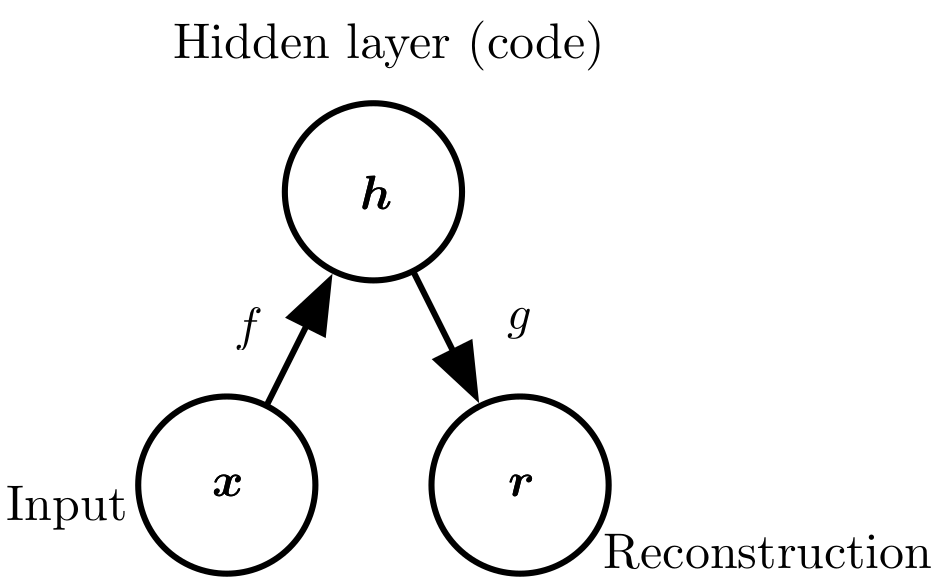

Όπως είπαμε και στη διάλεξη, οι **αυτοκωδικοποιητές** (*autoencoders*) είναι νευρωνικά δίκτυα τα οποία εκπαιδεύονται στο να αντιγράφουν την είσοδό τους στην έξοδό τους. Εσωτερικά αποτελούνται από κρυφό επίπεδο $\mathbf{h}$, στο οποίο αναπαρίσταται (κωδικοποιείται) η είσοδος, ενώ το δίκτυο περιλαμβάνει δύο μέρη:
1. τη συνάρτηση **κωδικοποίησης** (*encoder function*) $\mathbf{h} = f(x)$
1. τη συνάρτηση **αποκωδικοποίησης** (*decoder function*) $\mathbf{r} = g(\mathbf{h})$


Η εκπαίδευση τους πραγματοποιείται είτε μέσω τεχνικών οπίσθιας διάδοσης του σφάλματος (backpropagation) είτε μέσω **επανακυκλοφορίας** (recirculation), όπου συγκρίνεται η ενεργοποίηση των νευρώνων στην αρχική είσοδο και στην αναπαράσταση. Σε αυτό το notebook, η εκπαίδευση των δικτύων που θα δούμε βασίζεται στην πρώτη τεχνική.

Οι αυτοκωδικοποιητές παρουσιάστηκαν για πρώτη φορά στα μέσα της δεκαετίας του 1980. Αν και η λειτουργία τους προσομοιάζει αρκετά με τους **απωλεστικούς αλγορίθμους συμπίεσης** (*lossy compresion algorithms*) όπως θα δούμε στη συνέχεια, χρησιμοποιούνται κυρίως σε προβλήματα **μείωσης διαστατικότητας** (*dimensionality reduction*) και **εξαγωγής χαρακτηριστικών** (*feature extraction*).

## Εισαγωγή


### Εισαγωγή Βιβλιοθηκών

Στη συνέχεια εισάγουμε τις κλάσεις και τις μεθόδους που πρόκειται να χρησιμοποιήσουμε. Επίσης για να μπορούμε να αναπαράξουμε τα αποτελέσματα που θα λάβουμε, αρχικοποιούμε τη γεννήτρια ψευδοτυχαίων αριθμών χρησιμοποιώντας την ίδια σπορά (εδώ τον αριθμό $2021$).

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Θέτουμε σπορά (seed) στη γεννήτρια ψευδο-τυχαίων αριθμών για να λάβουμε
# ίδια αποτελέσματα

np.random.seed(2022)

### Ορισμός συναρτήσεων

Ορίζουμε δύο συναρτήσεις (μεθόδους) που πρόκειται να χρησιμοποιήσουμε για την παρουσίαση των αποτελεσμάτων, την *compare_digits()* και την *display_digits()*

In [ ]:
def compare_digits(test, decoded, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()
  
  
def display_digits(data, n=10):
  plt.figure(figsize=(20, 2))
  for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

## Δεδομένα

Για να κατανοήσουμε καλύτερα τη λειτουργία των αυτοκωδικοποιητών, θα χρησιμοποιήσουμε το (γνώστό σε προβλήματα βαθιάς μηχανικής μάθησης) dataset [MNIST,](http://yann.lecun.com/exdb/mnist/), το οποίο περιέχει $70.000$ σκαναρισμένες εικόνες ψηφίων που αντιστοιχούν στους αριθμούς $0$ ως $9$, όπως αυτοί έχουν γραφτεί από διαφορετικούς ανθρώπους.

Η κάθε εικόνα έχει μέγεθος $28\times28$ pixels και είναι ασπρόμαυρη. Επιπλέον, οι δημιουργοί του dataset τις έχουν χωρίσει σε δύο σύνολα, στο σύνολο εκπαίδευσης (που περιέχει $60.000$ εικόνες) και στο σύνολο ελέγχου (που περιέχει $10.000$ εικόνες). 

Μιας και το MNIST dataset παρέχεται (και) μέσω του keras, το φορτώνουμε μέσω αυτής της βιβλιοθήκης. Κατόπιν μετατρέπουμε την δισδιάστατη εικόνα σε ένα διάνυσμα $784$ χαρακτηριστικών και τέλος μετασχηματίζουμε γραμμικά τις τιμές των pixels από το $[0,255]$ στο $[0,1]$ μέσω της κλάσης *MinMaxScaler* του scikit-learn.

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(x_train.shape)
print(x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


## Υποπλήρης αυτοκωδιοποιητής

Σύμφωνα με τα όσα είπαμε στη διάλεξη,  κατά την εκπαίδευση των αυτοκωδικοποιητών δεν μας ενδιαφέρει τόσο η διαδικασία της αντιγραφής, όσο το να μάθει το δίκτυο να εξάγει και να αποτυπώνει στο επίπεδο κωδικοποίησης ($\mathbf{h}$) χρήσιμες ιδιότητες του χώρου εισόδου ($\mathbf{x}$). Ένας τρόπος για να αποτρέπουμε το δίκτυο από το να μάθει απλά να αντιγράφει την είσοδό του στην έξοδό του είναι να επιβάλλουμε τον περιορισμό η διάσταση της κωδικοποίησης να είναι μικρότερη της διάστασης της εισόδου ($\dim(\mathbf{h}) < \dim(\mathbf{x}))$, κατασκευάζοντας κατ' αυτόν τον τρόπο τους **υποπλήρεις αυτοκωδικοποιητές** (*underbomplete autoencoders*)

Στο παράδειγμα που εξετάζουμε, η διάσταση της εισόδου είναι $28\times28 = 784$ χαρακτηριστικά. Θα την περιορίσουμε (αυθαίρετα) στα $32$ (επιτυγχάνοντας ένα λόγο συμπίεσης $24.5$)

In [ ]:
dim_x = 28*28
dim_h = 32

Επιλέγουμε για συνάρτηση κωδικοποίησης την [Rectified Linear Unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) και για συνάρτηση αποκωδικοποίησης τη [σιγμοειδή](https://en.wikipedia.org/wiki/Sigmoid_function).  Έτσι η συνάρτηση κωδικοποίησης γίνεται $f(\mathbf{x}) = \max(0, \mathbf{w}_e\mathbf{x} + \mathbf{b}_e)$ και η συνάρτηση αποκωδικοποίησης $g(\mathbf{h}) = S(\mathbf{w}_d\mathbf{h} + \mathbf{b}_d)$. Κατά τη διάρκεια της εκπαίδευσης (που πραγματοποιείται με τη μέθοδο Adam), το δίκτυο μαθαίνει τα βάρη ($\mathbf{w}_e, \mathbf{w}_d$) και τις πολώσεις ($\mathbf{b}_e, \mathbf{b}_d$). Τέλος, η συνάρτηση σφάλματος που βελτιστοποιείται είναι η [δυαδική διασταυρούμενη εντροπία](https://en.wikipedia.org/wiki/Cross_entropy)

In [ ]:
autoencoder = Sequential([
    Dense(dim_h, activation='relu', input_shape=(dim_x,), name="encoder"),
    Dense(dim_x, activation='sigmoid', name="decoder")
])

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Dense)             (None, 32)                25120     
                                                                 
 decoder (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Εκπαιδεύουμε το δίκτυο που ορίσαμε προηγουμένως για 20 εποχές και με batch size 64. Προσέξτε ότι, μιας και πρόκειται για αυτοκωδικοποιητή, η είσοδος και η έξοδος ταυτίζονται (x_train).

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
938/938 [==============================] - 6s 4ms/step - loss: 0.1905 - val_loss: 0.1332
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1193 - val_loss: 0.1073
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1029 - val_loss: 0.0976
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0970 - val_loss: 0.0945
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0951 - val_loss: 0.0933
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0944 - val_loss: 0.0928
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0940 - val_loss: 0.0926
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0938 - val_loss: 0.0925
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0936 - val_loss: 0.0924
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0935 - val_loss: 0.0923

Παρατηρούμε ότι δεν παρουσιάστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση. Το σφάλμα εκπαίδευσης ξεκίνησε από το $0.19$, έπεσε γρήγορα μετά τις πρώτες εποχές  και τέλος σταθεροποιήθηκε γύρω στο $0.09$. Παρόμοια συμπεριφορά εμφάνισε και το σφάλμα επαλήθευσης.


Για να μπορέσουμε να εκτιμήσουμε την είσοδο και την έξοδο του αυτοκωδικοποητή που ορίσαμε προηγουμένως, κατασκευάζουμε τα αντίστοιχα δίκτυα. Προσέξτε ότι στον ορισμό τους δεν χρησιμοποιούμε την κλάση *Dense* όπως πριν, αλλά αναφερόμαστε απευθείας στα επίπεδα του αυτοκωδικοποιητή. Ο λόγος που το κάνουμε αυτό είναι γιατί θέλουμε να αντιγράψουμε τις τιμές των βαρών ($\mathbf{w}_e, \mathbf{w}_d$) και των πολώσεων ($\mathbf{b}_e, \mathbf{b}_d$) που προέκυψαν από την εκπαίδευση του δικτύου.

In [ ]:
encoder = Sequential([
    autoencoder.layers[-2]
])

decoder = Sequential([
    autoencoder.layers[-1]
])

h = encoder.predict(x_test)
x_test_out = decoder.predict(h)

Μέσω της μεθόδου *compare_digits()* που ορίσαμε στην αρχή του notebook, θα εμφανίσουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του αυτοκωδικοποιητή

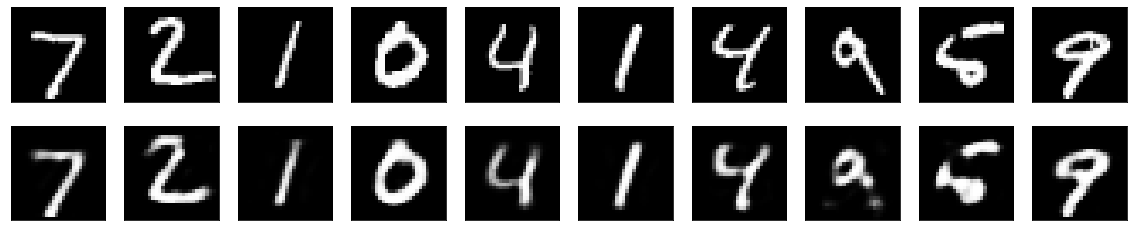

In [ ]:
compare_digits(x_test, x_test_out)

Απ' ότι φαίνεται, παρότι ο αυτοκωδικοποιητής χάνει λίγο σε λεπτομέρεια (εμφανέστερα στο 8<sup>ο</sup>  ψηφίο που είναι ο αριθμός $9$) κατορθώνει να μάθει σε ικανοποιητικό βαθμό τα χαρακτηριστικά της εισόδου του συγκεκριμένου dataset.

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηριστικά)

In [ ]:
pd.set_option('display.max_columns', dim_h) #display 32 columns
pd.DataFrame(data=h[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

1          2          3          4          5          6   \
1    0.278459   4.993359   8.923170   3.718353   6.833389   2.927623   
2    5.936008   6.739917   2.289088   2.729873   3.286109  11.099452   
3    6.479818   6.435046  10.301208   5.994383   1.300322   5.336410   
4   13.374728   8.856445   3.523794   6.863531  13.360771  10.215889   
5    3.925114  10.497985   0.259050   5.439044   7.439397   3.107438   
6    7.527451   8.410683  12.611418   7.209468   1.393248   6.959711   
7    3.706910  10.056638   6.028575   7.780162  10.733333   5.210862   
8    5.141837   5.160539   4.072979   5.797371   5.737465   8.908172   
9    3.603753  19.453999   6.216784  13.159901   0.068002   0.415679   
10  10.995329  10.957130   8.390804   9.664711   9.120410   7.126783   

           7          8          9          10         11         12  \
1    4.940902  10.928657   8.570151   2.325059   8.477364   1.635062   
2    2.858269   0.824681   9.246374   8.675496  16.788637   9.062277   
3    2.814665   7.659648   2.486752   4.080053   1.448237   5.693610   
4   14.168859   7.116362  14.703979   5.282695  19.108540  13.838170   
5    7.305968   8.967360  11.076322   8.170824   2.082158   3.749583   
6    2.581907   9.834108   4.084264   4.888916   2.955013   6.688427   
7    2.570615   2.257583   7.261777   5.161815   7.437240   3.760556   
8    5.373975  12.222766   6.744655   7.634873   7.359091   4.489670   
9    7.116793   5.071142  10.592062  10.339185   4.467041   7.423836   
10   5.527143  21.217817   9.423884   2.461668  13.796988   6.366385   

           13         14         15         16        17         18  \
1    5.921434   3.569870   7.349653  10.735209  5.422180   5.242826   
2    1.858423   3.014078   4.647469   0.809294  0.000000   6.435779   
3    4.214201   5.023021   2.962403   0.322986  2.337703   3.643236   
4   19.245857  12.244785   2.539757   8.723411  8.206582   9.942135   
5    5.564302   2.828669   2.270855   9.923261  8.510496   6.461779   
6    5.484002   6.646692   4.858149   2.799388  5.003658   3.441094   
7    5.314866   1.134132   8.052665  10.540598  2.178543   8.133670   
8    7.822894   6.210207   4.807855   8.757026  3.522576   7.665174   
9   19.447124   6.305339   9.271478  10.324262  8.867357   3.537443   
10  10.895712   8.252220  10.893495   9.375355  7.703602  10.212780   

           19         20         21        22         23         24  \
1   10.897867  14.605156   8.017391  5.365447   5.615178  10.902504   
2    7.581448   2.364764   9.881592  0.336656   6.842902   9.740459   
3    3.736769   3.295315   4.136241  2.829758   4.810700   3.022056   
4    8.156504   6.852072  18.434816  9.213830  15.382076  11.671512   
5    6.942750   7.906198   4.277120  1.972992   7.145979   3.641954   
6    4.580280   5.779872   6.261154  6.015269   6.821531   2.075444   
7    6.040919  19.160074   5.643502  6.715466  11.163214   4.654081   
8    2.312509   2.438572   0.000000  7.993263   5.094520   4.143302   
9    7.913661   7.569597  10.676063  8.862188   7.265996   8.281490   
10   4.276613  19.126293  10.816746  6.225398   9.722862  11.713161   

           25         26         27         28         29         30  \
1    9.861597   2.811731   6.217370   5.078727   2.654399   2.362486   
2   10.447378  13.615768  13.519724  12.379040  14.399604  12.429740   
3    5.976998   5.702085   4.522603   6.002566   0.495771   4.637629   
4   12.327831   8.147844  10.902890   6.981831   9.573035   6.538550   
5    9.033732   4.434889   6.711353   2.756625   6.222973   6.674484   
6    6.262487   6.757403   6.088681   8.072386   1.858859   4.213774   
7    9.848224   5.853583   5.148960   4.688281   8.835505  10.605433   
8    9.760029   8.525081   8.876170   0.000000   7.859247   7.038826   
9   14.200814   6.783943   9.072655   5.158940   9.741718  10.867065   
10  11.908315   3.410884  11.769618   9.255741   8.388183   3.694173   

           31         32  
1    5.432361   9.119932  
2    8.165005 

Οι αυτοκωδικοποιητές μαθαίνουν κατανεμημένες αναπαραστάσεις (distributed representations) της εισόδου τους. Συνεπώς αναμένουμε οι αναπαραστάσεις όμοιων ψηφίων στο επίπεδο κωδικοποίησης να είναι περισσότερο "κοντά". Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των $10$ πρώτων ψηφίων του συνόλου ελέγχου.

In [ ]:
pd.DataFrame(data=cosine_similarity(h[0:10]), columns=range(1,11), index=range(1,11)).head(10)

1         2         3         4         5         6         7   \
1   1.000000  0.679175  0.764445  0.823973  0.847805  0.799379  0.864337   
2   0.679175  1.000000  0.739715  0.817525  0.725864  0.731916  0.752440   
3   0.764445  0.739715  1.000000  0.794944  0.772107  0.983588  0.753580   
4   0.823973  0.817525  0.794944  1.000000  0.851867  0.811396  0.803923   
5   0.847805  0.725864  0.772107  0.851867  1.000000  0.789035  0.859613   
6   0.799379  0.731916  0.983588  0.811396  0.789035  1.000000  0.788238   
7   0.864337  0.752440  0.753580  0.803923  0.859613  0.788238  1.000000   
8   0.792766  0.763906  0.810608  0.848761  0.855829  0.824946  0.795629   
9   0.799691  0.729228  0.813996  0.840947  0.886215  0.833666  0.827438   
10  0.923981  0.735690  0.847206  0.879449  0.860500  0.878268  0.868047   

          8         9         10  
1   0.792766  0.799691  0.923981  
2   0.763906  0.729228  0.735690  
3   0.810608  0.813996  0.847206  
4   0.848761  0.840947  0.879449  
5   0.855829  0.886215  0.860500  
6   0.824946  0.833666  0.878268  
7   0.795629  0.827438  0.868047  
8   1.000000  0.808467  0.859179  
9   0.808467  1.000000  0.824825  
10  0.859179  0.824825  1.000000

Αναμένουμε το 3<sup>ο</sup> και το 6<sup>ο</sup>  ψηφίο να είναι εγγύτερα (αριθμός $1$), όπως αντίστοιχα το 5<sup>ο</sup> και το 7<sup>ο</sup> (αριθμός $4$) και το 8<sup>ο</sup> και το 10<sup>ο</sup>  (αριθμός $9$). Αυτό ισχύει για το 3<sup>ο</sup> και το 6<sup>ο</sup>  ψηφίο (ομοιότητα $0,98$) και για το 8<sup>ο</sup> με το 10<sup>ο</sup> (ομοιότητα $0,85$). Ωστόσο το 5<sup>ο</sup> δεν είναι πιο όμοιο με το 7<sup>ο</sup>, αλλά με το 10<sup>ο</sup> . Επίσης, γενικότερα, ακόμα και για τα σημεία που δεν μοιάζουν καθόλου μεταξύ τους, οι ομοιότητες είναι υψηλές (η πλειοψηφία κυμαίνεται μεταξύ $0,70-0,98$).

Καταλήγουμε στο συμπέρασμα ότι μπορεί ναι μεν η εκπαίδευση του αυτοκωδικοποιητή να ολοκληρώθηκε με χαμηλό σφάλμα εκπαίδευσης και γενίκευσης, ωστόσο η αναπαράσταση που έμαθε χρήζει βελτίωσης. Η ζητούμενη βελτίωση μπορεί να επιτευχθεί μεταβάλλοντας τα χαρακτηριστικά του αυτοκωδικοποιητή (μέγεθος κωδικοποίησης, συναρτήσεις (από)κωδικοποίησης, αλγόριθμος σφάλματος και εκπαίδευσης) αλλά και εξετάζοντας διαφορετικές αρχιτεκτονικές αυτοκωδικοποιητών, όπως θα δούμε παρακάτω.

Πριν προχωρήσουμε, ας δούμε τη μέση τιμή των χαρακτηριστικών του υποπλήρη αυτοκωδικοποιητή 

In [ ]:
print(h.mean())

7.7969995


## Αραιός αυτοκωδικοποιητής

Στον **αραιό αυτοκωδικοποιητή** (*sparse autoencoder*) επιβάλλουμε όρο ποινής αραιότητας $\Omega(\mathbf{h})$ του επιπέδου κωδικοποίησης $\mathbf{h}$ στη διαδικασία μάθησης (παράμετρος *activity_regularizer* της κλάσης [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

Στη συγκεκριμένη περίπτωση επιλέγουμε $L_1$ κανονικοποίηση με βάρος $\lambda=10^{-4}$, δηλαδή $\Omega(\mathbf{h}) = 10^{-4}||\mathbf{h}||$

In [ ]:
sparse_autoencoder = Sequential([
    Dense(dim_h, activation='relu', 
          activity_regularizer=regularizers.l1(10e-4), 
          input_shape=(dim_x,), name='encoder'),
    Dense(dim_x, activation='sigmoid', name='decoder')
])

sparse_autoencoder.summary()

sparse_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Dense)             (None, 32)                25120     
                                                                 
 decoder (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Όπως και προηγουμένως, εκπαιδεύουμε για $30$ εποχές με μέγεθος δέσμης $64$

In [ ]:
sparse_autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
938/938 [==============================] - 5s 5ms/step - loss: 0.2315 - val_loss: 0.1757
Epoch 2/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1651 - val_loss: 0.1541
Epoch 3/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1494 - val_loss: 0.1430
Epoch 4/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1409 - val_loss: 0.1363
Epoch 5/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1352 - val_loss: 0.1320
Epoch 6/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1316 - val_loss: 0.1288
Epoch 7/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1289 - val_loss: 0.1264
Epoch 8/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1268 - val_loss: 0.1246
Epoch 9/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1251 - val_loss: 0.1229
Epoch 10/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1237 - val_loss: 0.1219

Παρατηρούμε ότι ούτε σε αυτή την περίπτωση παρουσιάστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση. Το σφάλμα εκπαίδευσης ωστόσο είναι $0.11$, ελαφρώς μεγαλύτερο απ' ότι προηγουμένως ($0.09$). 

Όπως και πριν, ορίζουμε τα δίκτυα του κωδικοποιητή και του αποκωδικοποιητή.

In [ ]:
sparse_encoder = Sequential([
    sparse_autoencoder.layers[-2]
])

sparse_decoder = Sequential([
    sparse_autoencoder.layers[-1]
])

h_sparse = sparse_encoder.predict(x_test)
x_test_out_sparse = sparse_decoder.predict(h_sparse)

Εμφανίζουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του αραιού αυτοκωδικοποιητή

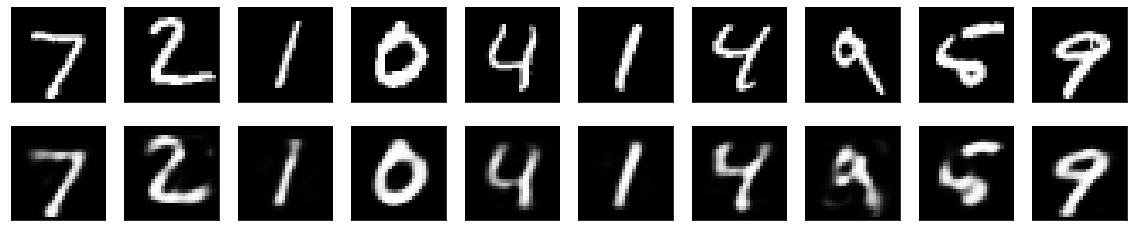

In [ ]:
compare_digits(x_test, x_test_out_sparse)

Απ' ότι φαίνεται, ο αραιός αυτοκωδικοποιητής εμφανίζει παρόμοια συμπεριφορά με τον υποπλήρη, χάνοντας λίγο σε λεπτομέρεια (εμφανέστερα στο 8<sup>ο</sup>  ψηφίο που είναι ο αριθμός $9$), κατορθώνοντας όμως να μάθει σε ικανοποιητικό βαθμό τα χαρακτηριστικά της εισόδου του συγκεκριμένου dataset.

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηριστικά)

In [ ]:
pd.DataFrame(data=h_sparse[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

1         2    3         4    5         6         7         8   \
1   0.628353  0.115500  0.0  0.307780  0.0  0.346957  1.513803  0.000000   
2   0.025803  0.059035  0.0  0.395665  0.0  0.702175  0.302183  0.587467   
3   0.203848  1.300940  0.0  0.125009  0.0  0.251355  0.687411  0.150186   
4   1.434067  0.125283  0.0  0.260463  0.0  0.297093  0.309443  0.444481   
5   0.281914  0.089141  0.0  0.259486  0.0  0.356109  0.261907  0.267480   
6   0.044960  1.538753  0.0  0.172954  0.0  0.175970  0.706392  0.201009   
7   0.139956  0.016441  0.0  0.701561  0.0  0.329862  1.000640  0.373804   
8   0.260010  0.000000  0.0  0.687085  0.0  0.271771  0.354193  0.208693   
9   0.230537  0.254417  0.0  0.000000  0.0  0.751973  0.003484  0.293036   
10  0.178446  0.658707  0.0  0.109760  0.0  0.045533  1.657405  0.000000   

          9         10        11        12        13        14        15  \
1   0.232328  0.035022  0.259529  0.202672  0.854714  0.245518  0.098951   
2   0.813315  0.467145  1.638929  0.000000  0.000000  0.735506  0.000000   
3   0.865885  0.108182  0.424641  0.063662  0.027994  0.506377  0.329155   
4   0.258744  0.423534  0.851765  1.077477  0.347314  1.235502  0.112792   
5   0.266315  0.315822  0.648225  0.760938  0.715109  0.116973  0.616645   
6   0.879262  0.139374  0.449098  0.195885  0.084701  0.374462  0.286306   
7   0.173278  1.032704  0.620142  0.076112  1.196062  0.337663  0.564082   
8   0.634694  0.177495  0.000000  0.324396  0.000000  0.000000  0.248999   
9   0.952627  1.054764  0.514785  1.598958  0.456338  0.355945  0.502092   
10  0.000000  0.163887  0.087606  0.443464  0.367092  0.144266  0.466449   

          16        17        18        19        20   21        22   23  \
1   0.870629  0.665205  0.154917  0.304944  0.460579  0.0  0.861946  0.0   
2   0.000000  0.000000  0.111065  0.209542  0.110983  0.0  0.532369  0.0   
3   0.377862  0.366226  0.207740  0.016675  0.225639  0.0  0.037222  0.0   
4   0.656041  0.174593  0.329419  0.438525  0.000000  0.0  0.479491  0.0   
5   1.247465  0.158902  0.187564  0.548465  1.116875  0.0  0.392125  0.0   
6   0.292171  0.499279  0.310038  0.118096  0.037634  0.0  0.063387  0.0   
7   0.203033  0.537815  0.000000  0.343610  1.195977  0.0  0.673785  0.0   
8   0.829826  0.566779  0.459225  0.000000  0.169657  0.0  0.731986  0.0   
9   0.229631  0.730280  0.000000  0.746445  0.577898  0.0  0.000000  0.0   
10  0.296545  0.000000  0.264687  0.317184  0.032551  0.0  1.003860  0.0   

          24        25        26        27        28        29        30  \
1   0.976787  0.000000  0.118958  0.000000  0.215739  0.000000  0.850150   
2   0.000000  0.245061  1.251593  0.458420  0.000000  0.330041  0.992572   
3   0.016771  0.000000  0.269293  0.000000  0.059867  0.166367  0.211450   
4   0.647666  1.520794  0.133392  1.002524  0.003985  1.013301  0.662822   
5   0.314020  0.360302  0.470463  0.062794  0.278963  0.753050  0.432562   
6   0.179918  0.099163  0.312166  0.075095  0.149529  0.000000  0.138239   
7   0.124366  0.227611  0.159247  0.249144  0.245703  0.037466  0.067051   
8   0.000000  0.053053  0.976706  0.436251  0.000000  0.866402  0.000000   
9   0.223002  0.137597  0.748435  0.000000  0.244225  0.213154  0.322097   
10  0.905548  0.442044  0.000000  0.410887  0.256278  0.495927  0.306671   

          31        32  
1   0.307236  0.155699  
2   0.053406  0.616016  
3   0.406887  0.458270  
4   0.166419  0.753081  
5   0.840663  0.002456  
6   0.411481  0.362416  
7   0.589067  0.039906  
8   0.680446  0.086612  
9   0.960753  0.715349  
10  1.127346  0.593291

Παρατηρούμε ότι οι τιμές που λαμβάνουν τα χαρακτηριστικά είναι πιο χαμηλές σε σύγκριση με την περίπτωση του υποπλήρη αποκωδικοποιητή (κάποιες είναι και μηδενικές), πράγμα που οφείλεται στην επίδραση του όρου αραιότητας. 

Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των 10 πρώτων ψηφίων του συνόλου ελέγχου.

In [ ]:
pd.DataFrame(data=cosine_similarity(h_sparse[0:10]), columns=range(1,11), index=range(1,11)).head(10)

1         2         3         4         5         6         7   \
1   1.000000  0.443920  0.539638  0.594258  0.631503  0.528808  0.720812   
2   0.443920  1.000000  0.479812  0.618525  0.523049  0.429200  0.541340   
3   0.539638  0.479812  1.000000  0.416507  0.484919  0.968940  0.443584   
4   0.594258  0.618525  0.416507  1.000000  0.641725  0.411774  0.492874   
5   0.631503  0.523049  0.484919  0.641725  1.000000  0.437244  0.719640   
6   0.528808  0.429200  0.968940  0.411774  0.437244  1.000000  0.428118   
7   0.720812  0.541340  0.443584  0.492874  0.719640  0.428118  1.000000   
8   0.585708  0.485486  0.478221  0.524596  0.699624  0.442948  0.598969   
9   0.472940  0.570722  0.477514  0.587810  0.782337  0.474216  0.638377   
10  0.740887  0.408226  0.575004  0.612528  0.617243  0.588981  0.658630   

          8         9         10  
1   0.585708  0.472940  0.740887  
2   0.485486  0.570722  0.408226  
3   0.478221  0.477514  0.575004  
4   0.524596  0.587810  0.612528  
5   0.699624  0.782337  0.617243  
6   0.442948  0.474216  0.588981  
7   0.598969  0.638377  0.658630  
8   1.000000  0.574374  0.558564  
9   0.574374  1.000000  0.476770  
10  0.558564  0.476770  1.000000

Παρατηρούμε καταρχήν πως το εύρος των ομοιοτήτων συνημιτόνου είναι μεγαλύτερο σε σύγκριση με την προηγούμενη περίπτωση. Αυτό οφείλεται  στην αραιότητα που επιβάλλει στις παραγόμενες αναπαραστάσεις ο όρος ποινής, κάνοντάς τες να λαμβάνουν τιμές πιο κοντά στο $0$.

Παρότι το σφάλμα εκπαίδευσης ήταν ελαφρώς χειρότερο, παρατηρούμε ότι η αναπαράσταση που επιτύχαμε είναι καλύτερη. Για παράδειγμα, το πιο όμοιο στο 3<sup>ο</sup> ψηφίο είναι το 6<sup>ο</sup> (ομοιότητα $0,97$) και το αντίστοιχο ισχύει και για το  6<sup>ο</sup>  ψηφίο (και τα δύο απεικονίζουν τον αριθμό $1$). Ωστόσο, αντίστοιχα συμπεράσματα δεν μπορούν να βγούν και για τα υπόλοιπα ζεύγη ψηφίων (5<sup>ο</sup>, 7<sup>ο</sup> και 8<sup>ο</sup>, 10<sup>ο</sup>), μιας και παρά την αύξηση του εύρους των ομοιοτήτων συνημιτόνου, πιο κοντινό στο 5<sup>ο</sup> ψηφίο είναι είναι το 9<sup>ο</sup>, ενώ στο 8<sup>ο</sup> το 5<sup>ο</sup>. Συνεπώς πρέπει να αναζητήσουμε καλύτερες υπερπαραμέτρους για τη συγκεκριμένη μεθοδολογία ή να προχωρήσουμε σε άλλες τεχνικές αυτοκωδικοποίησης



In [ ]:
print(h_sparse.mean())

0.35433093


Τέλος, παρατηρούμε ότι η μέση τιμή των χαρακτηριστικών του αραιού αυτοκωδικοποιητή είναι χαμηλότερη σε σύγκριση με του  υποπλήρη ($0,35$ και $7,79$ αντίστοιχα)

## Αυτοκωδικοιητής απαλοιφής θορύβου

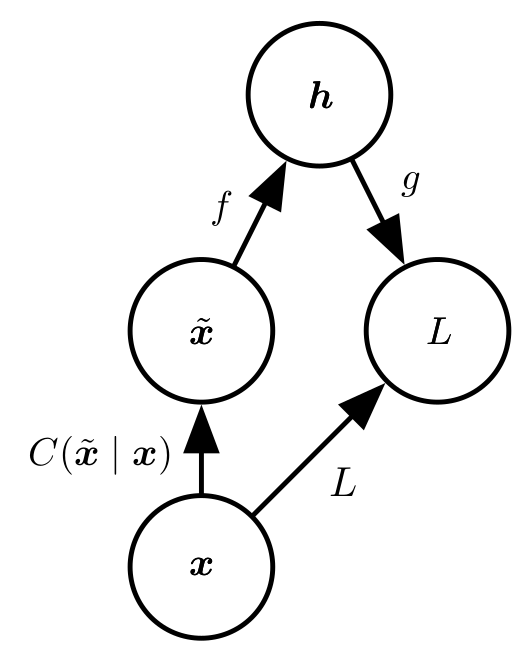

Σε αυτή την περίπτωση επιβάλλουμε στον αυτοκωδικοποιητή να μάθει τα χαρακτηριστικά της εισόδου $\mathbf{x}$ , "αλλοιώνοντας" την μέσω της προσθήκης θορύβου κανονικής κατανομής με μέση τιμή $\mu=0$ και τυπική απόκλιση $\sigma = 1$: $\mathcal{N}(0, 1)$. Επίσης ορίζουμε τον βαθμό συνεισφοράς του θορύβου (noise factor) στα αρχικά δεδομένα ίσο με $n_f = 0.3$. Έχουμε δηλαδή:

$\widetilde{\mathbf{x}} = \mathbf{x} + 0.3\mathcal{N}(0, 1)$ 

In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, 
                                                          size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, 
                                                        size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 784)
(10000, 784)


Ας δούμε τα $10$ πρώρα ψηφία του συνόλου ελέγχου μετά την προσθήκη του θορύβου

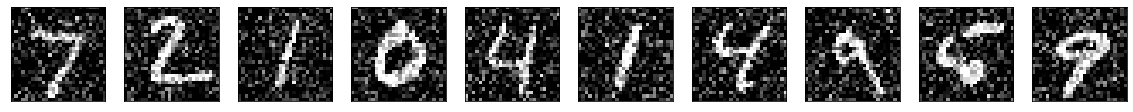

In [ ]:
display_digits(x_test_noisy)

Το δίκτυο έχει την ίδια δομή με έναν υποπλήρη αυτοκωδικοποιητή

In [ ]:
noisy_autoencoder = Sequential([
    Dense(dim_h, activation='relu', input_shape=(dim_x,), name='encoder'),
    Dense(dim_x, activation='sigmoid', name='decoder')
])


noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Το εκπαιδεύουμε για ίδιο αριθμό εποχών

In [ ]:
noisy_autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
938/938 [==============================] - 4s 4ms/step - loss: 0.2038 - val_loss: 0.2737
Epoch 2/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1296 - val_loss: 0.2877
Epoch 3/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1161 - val_loss: 0.2898
Epoch 4/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1127 - val_loss: 0.2854
Epoch 5/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1098 - val_loss: 0.2763
Epoch 6/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1091 - val_loss: 0.2691
Epoch 7/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1086 - val_loss: 0.2491
Epoch 8/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1083 - val_loss: 0.2462
Epoch 9/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1080 - val_loss: 0.2338
Epoch 10/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1078 - val_loss: 0.2165

Παρατηρούμε ότι ούτε σε αυτή την περίπτωση παρουσιάστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση, με το αντίστοιχο σφάλμα να είναι στα ίδια επίπεδα με τον αραιό αυτοκωδικοποιητή (και ελαφρώς χειρότερο απ' ότι στον υποπλήρη αυτοκωδικοποιητή)

Ορίζουμε τα δίκτυα του κωδικοποιητή και του αποκωδικοποιητή.

In [ ]:
noisy_encoder = Sequential([
    noisy_autoencoder.layers[-2]
])

noisy_decoder = Sequential([
    noisy_autoencoder.layers[-1]
])

h_noisy = noisy_encoder.predict(x_test_noisy)
x_test_out_noisy = noisy_decoder.predict(h_noisy)

Εμφανίζουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου (με θόρυβο) και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του αραιού αυτοκωδικοποιητή

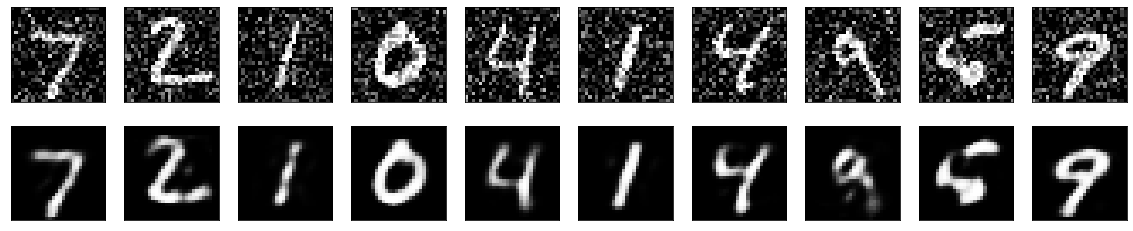

In [ ]:
compare_digits(x_test_noisy, x_test_out_noisy)

Απ' ότι φαίνεται, ο αυτοκωδικοποητής απαλοιφής θορύβου κατορθώνει να γενικεύσει, μιας και μπορεί να αναπαριστά τα ψηφία χωρίς θόρυβο (ωστόσο όχι τόσο καλά όσο οι προηγούμενοι δύο).

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηριστικά)

In [ ]:
pd.DataFrame(data=h_noisy[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

1         2         3          4         5         6          7   \
1    7.124163  1.557947  4.717067   8.738967  9.184303  2.512586   5.491440   
2    7.210382  3.203952  4.871570   4.682888  9.855583  0.000000   6.122005   
3    0.000000  3.133946  2.381696   7.578915  4.177436  5.254775   7.272166   
4   14.438522  4.519253  7.181153   8.041427  3.462029  8.861394  13.108335   
5    9.047188  0.597438  4.482448  11.329772  6.068141  8.359489   5.215342   
6    1.688753  4.631027  2.250526  10.199457  4.299136  5.984968   8.552590   
7    5.965250  6.820981  4.934614   8.522879  7.118964  1.634661   8.350361   
8    2.740604  0.760676  5.341214   9.127872  5.593085  8.831970   0.000000   
9   10.271283  0.186805  0.513777   9.812809  4.510416  3.980463  12.889648   
10   3.866538  6.356163  7.872947   9.636909  5.973860  2.899837   9.524541   

           8          9         10         11         12         13  \
1    2.350985   8.379706  5.669083   1.789909   4.041935   7.177357   
2    6.469180   2.819023  1.427513   7.676765   4.394387   6.884121   
3    2.849035   5.729824  3.322835   5.068453   3.348041   3.035631   
4   17.112473  12.320623  7.680361   9.923251   1.511040   9.313644   
5   10.573517   6.378204  6.636286   6.994560  15.281645   7.136627   
6    4.197183   9.906446  3.855439   3.490766   2.604444   4.499990   
7    9.728414   2.069972  7.893134   4.616130  10.344790  10.487406   
8    8.204591   6.968821  4.772185   5.229445   4.615471   4.681351   
9   10.537848   0.000000  3.902308  10.407688  13.849167   1.231913   
10   6.523343  13.916467  8.906792   5.522456   5.043368   6.789207   

           14         15         16         17         18        19  \
1    9.326023   6.491264   3.301632   4.405304   5.788455  3.027997   
2    4.054319   9.906090  10.296770   4.069339   6.571632  5.147727   
3    3.600211   6.560457   6.735223   1.090274   3.154537  2.529744   
4   12.560197  10.362455  10.861809  12.444197   6.390733  4.254505   
5    9.979423   4.149689  10.320567   5.495817   3.576492  5.479141   
6    3.203405   7.486892   8.658140   1.719134   2.515719  1.967277   
7    7.231590   4.842589   3.665199   0.000000  10.160652  3.166788   
8    7.701185   0.951979   7.924859   3.127986   7.351323  2.008646   
9    8.542168   8.390510   9.588555   7.222625   7.797018  6.585293   
10  12.341784   7.666422   7.882033   3.820482   3.996220  3.074624   

           20        21         22        23         24         25         26  \
1    4.784885  4.919725   5.870145  1.108190   4.756354  11.473224   6.016305   
2    9.116496  4.877823   9.893925  1.507155  17.682682   4.481722   3.296634   
3    3.699942  4.099536   6.305476  6.694013   9.976813   6.827074   9.190104   
4    8.725282  7.010547  13.959457  5.560018  10.321554   8.586399   3.112247   
5    5.739326  3.912725   8.853047  5.112331   4.095608   7.088724   0.986576   
6    3.812319  4.988760   6.863031  8.708494  11.401463   7.853726  11.090387   
7    4.048474  7.835032   6.017535  6.714846   3.531478   4.433410   5.021740   
8    6.723373  5.477896   5.144547  4.055555   6.446991   3.629245   4.704415   
9    1.094635  3.756387  13.490206  7.113697   6.291767   9.452501  11.977864   
10  10.017066  3.031411   5.376337  6.629018   0.511333   5.950633  10.228496   

     27         28         29         30        31         32  
1   0.0   5.296844   6.173908   4.355196  4.224220  13.366877  
2   0.0  10.273795   5.951537   3.643845  3.244784   5.132721  
3   0.0   5.236670   4.991575   8.783922  3.228270   4.599844  
4   0.0  12.664075   3.026560   9.827706  4.842370   9.247440  
5   0.0   2.481551   4.389388   5.503516  4.326748   7.454122  
6   0.0   8.584077  10.133352  10.813301  5.870497   5.402645  
7   0.0   2.728784  10.593735   0.000000  5.537471  11.597893  
8   0.0   6.097329   7.885943   7.055706  2.978452   4.841427  
9   0.0   9.652856   5.050057   6.809986  7.857435   8.126180  
10  0.0  10.219034  10.397678  11.218162  3.1

Εδώ δεν υπάρχει ποινή αραιότητας, οπότε τα χαρακτηριστικά λαμβάνουν τιμές αντίστοιχες με τον υποπλήρη αυτοκωδικοποιητή. 

Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των 10 πρώτων ψηφίων του συνόλου ελέγχου.

In [ ]:
pd.DataFrame(data=cosine_similarity(h_noisy[0:10]), columns=range(1,11), index=range(1,11)).head(10)

1         2         3         4         5         6         7   \
1   1.000000  0.789608  0.823443  0.838738  0.836046  0.821143  0.853810   
2   0.789608  1.000000  0.834813  0.850115  0.770692  0.809331  0.761168   
3   0.823443  0.834813  1.000000  0.826169  0.786436  0.979694  0.762533   
4   0.838738  0.850115  0.826169  1.000000  0.868894  0.821700  0.776160   
5   0.836046  0.770692  0.786436  0.868894  1.000000  0.761608  0.849638   
6   0.821143  0.809331  0.979694  0.821700  0.761608  1.000000  0.755874   
7   0.853810  0.761168  0.762533  0.776160  0.849638  0.755874  1.000000   
8   0.830466  0.800174  0.856891  0.855305  0.884591  0.855099  0.813232   
9   0.797857  0.802063  0.846576  0.847590  0.873064  0.812985  0.812518   
10  0.891888  0.743035  0.864586  0.858865  0.822533  0.878848  0.825472   

          8         9         10  
1   0.830466  0.797857  0.891888  
2   0.800174  0.802063  0.743035  
3   0.856891  0.846576  0.864586  
4   0.855305  0.847590  0.858865  
5   0.884591  0.873064  0.822533  
6   0.855099  0.812985  0.878848  
7   0.813232  0.812518  0.825472  
8   1.000000  0.782434  0.867987  
9   0.782434  1.000000  0.783937  
10  0.867987  0.783937  1.000000

Παρότι δεν υπάρχει ποινή αραιότητας, οι ομοιότητες συνημιτόνου είναι ακόμα μεγαλύτερες σε σύγκριση με τις δύο προηγούμενες περιπτώσεις. Επίσης, πάλι το  3<sup>ο</sup> και το 6<sup>ο</sup>  ψηφίο είναι πιο όμοια μεταξύ τους, αλλά δεν ισχύει το ίδιο για τα υπόλοιπα ζεύγη ψηφίων  (5<sup>ο</sup>, 7<sup>ο</sup> και 8<sup>ο</sup>, 10<sup>ο</sup> ).


## Βαθύς Αυτοκωδικοποιητής

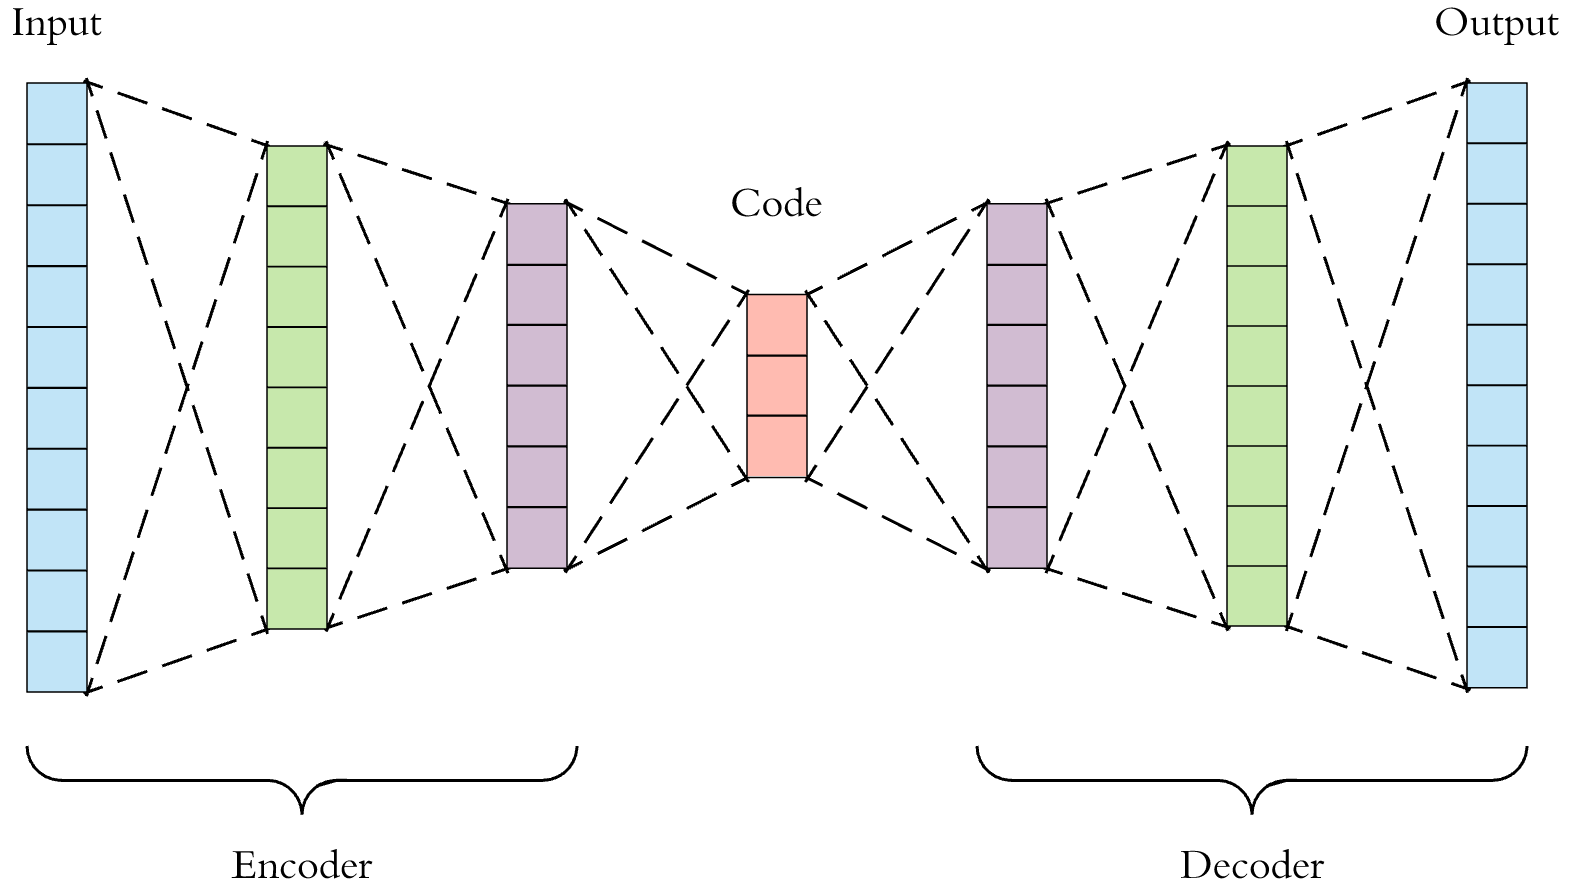

Στους **βαθείς αυτοκωδικοποιητές** (*deep autoencoders*) οι συναρτήσεις (από)κωδικοποίησης δεν αποτελούνται από ένα μόνο επίπεδο αλλά από περισσότερα. Στο παράδειγμα που εξετάζουμε, συνάρτηση κωδικοποίησης αποτελείται από $3$ επίπεδα με διαστάσεις $128, 64$ και $32$ αντίστοιχα και με συνάρτηση ενεργοποίησης την ReLU. Ίδιο αριθμό  επίπεδων (με ανάστροφη σειρά) έχει η συνάρτηση αποκωδικοποίησης, με το τελευταίο να έχει συνάρτηση ενεργοποίησης τη σιγμοειδή (για να "σπάσει" τη συμμετρία). Στη γενικότερη περίπτωση ωστόσο, δεν είναι υποχρεωτικό οι συναρτήσεις (απο)κωδικοποίησης να έχουν ίδιο αριθμό επιπέδων


In [ ]:
layer1_dim = 128
layer2_dim = 64

deep_autoencoder = Sequential([
    Dense(layer1_dim, activation='relu', input_shape=(dim_x,)),
    Dense(layer2_dim, activation='relu'),
    Dense(dim_h, activation='relu'),
    
    Dense(layer2_dim, activation='relu'),
    Dense(layer1_dim, activation='relu'),
    Dense(dim_x, activation='sigmoid')
])


deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Εκπαιδεύουμε για 30 εποχές

In [ ]:
deep_autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
938/938 [==============================] - 5s 5ms/step - loss: 0.1693 - val_loss: 0.1222
Epoch 2/30
938/938 [==============================] - 5s 5ms/step - loss: 0.1156 - val_loss: 0.1077
Epoch 3/30
938/938 [==============================] - 5s 5ms/step - loss: 0.1054 - val_loss: 0.1009
Epoch 4/30
938/938 [==============================] - 5s 5ms/step - loss: 0.1002 - val_loss: 0.0972
Epoch 5/30
938/938 [==============================] - 4s 5ms/step - loss: 0.0967 - val_loss: 0.0942
Epoch 6/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0939 - val_loss: 0.0920
Epoch 7/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0919 - val_loss: 0.0904
Epoch 8/30
938/938 [==============================] - 4s 5ms/step - loss: 0.0901 - val_loss: 0.0886
Epoch 9/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0885 - val_loss: 0.0874
Epoch 10/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0873 - val_loss: 0.0860

Παρατηρούμε ότι ούτε σε αυτή την περίπτωση παρουσιάστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση. Ωστόσο το σφάλμα εκπαίδευσης και επαλήθευσης είναι χαμηλότερο απ' ότι σε όλες τις άλλες περιπτώσεις

Ορίζουμε τα δίκτυα του κωδικοποιητή και του αποκωδικοποιητή.

In [ ]:
deep_encoder = Sequential([
    deep_autoencoder.layers[0],
    deep_autoencoder.layers[1],
    deep_autoencoder.layers[2]
])

deep_decoder = Sequential([
    deep_autoencoder.layers[-3],
    deep_autoencoder.layers[-2],
    deep_autoencoder.layers[-1]
])

h_deep = deep_encoder.predict(x_test)
x_test_out_deep = deep_decoder.predict(h_deep)

Εμφανίζουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου  και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του βαθύ αυτοκωδικοποιητή.

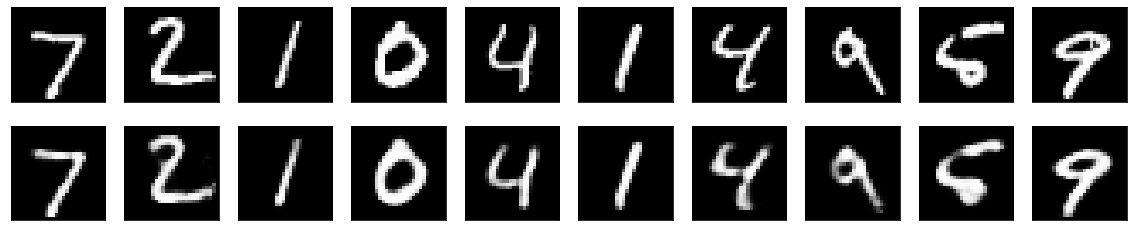

In [ ]:
compare_digits(x_test, x_test_out_deep)

Εκ πρώτης όψεως, ο βαθύς αυτοκωδικοποιητής έχει μάθει την καλύτερη αναπαράσταση σε σχέση με τους υπόλοιπους. 

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηριστικά)

In [ ]:
pd.DataFrame(data=h_deep[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

1          2          3          4         5         6          7   \
1   6.542177   8.857757   6.703946   9.405655  9.073322  9.164249  11.597959   
2   6.604321   7.088208  12.139620   9.868669  8.902825  9.826435   3.660714   
3   4.834949   6.772389   4.843103  13.076412  2.574854  6.035798   5.843778   
4   3.026507   6.901734   4.388583   5.679783  5.704003  8.890286   6.759668   
5   7.608638  11.262289  10.107612   4.543830  4.749797  5.540377   5.560997   
6   6.371461   5.655877   5.434442  13.571546  1.801749  6.398772   6.690269   
7   7.162456   9.902312  10.248958   5.796464  3.748058  6.745484   1.591061   
8   5.032586   6.399164   9.908869   5.345017  9.551335  8.486608   7.850884   
9   7.698266  10.703319   8.618189  10.982717  0.327366  8.871758   1.152244   
10  3.009320   6.435077   4.673842  10.816842  7.611547  9.728249  11.310684   

     8         9          10         11         12         13        14  \
1   0.0  5.355823   5.421817   7.121960   3.741157   8.306545  8.244712   
2   0.0  6.473565   5.572859   8.248769   8.508381   8.881842  1.431438   
3   0.0  7.154933   5.497584   7.284640   6.945042   8.366179  9.439101   
4   0.0  4.712311   4.412436   9.885013   1.557150  12.668872  2.272564   
5   0.0  8.121683   4.833846   9.151364   9.474709   4.286050  6.687075   
6   0.0  7.392459   5.189089   8.366626   7.614495   9.647287  9.981062   
7   0.0  7.518272   6.692183   6.970459   6.532276   2.435199  9.137291   
8   0.0  9.333015   7.130985   8.573651  11.011430   3.590932  5.327809   
9   0.0  6.761178  10.857974   6.806587   8.376683   5.429780  6.559338   
10  0.0  5.188200   4.032680  10.503522   6.017185   7.091296  7.291136   

          15         16        17         18         19         20        21  \
1   2.877028  10.311895  8.179958  10.165046  13.461031  13.158999  7.192036   
2   3.410547   9.397995  3.482427   8.420702   5.393271   6.946743  9.387028   
3   1.833269   3.414336  5.437970   8.786960   5.854282   5.177309  7.625758   
4   4.176289   4.620686  5.645949   3.026473   6.294371   6.476227  2.580101   
5   3.824684   7.637696  6.466880   6.159756  12.333704   8.047175  2.431629   
6   1.915986   4.750871  6.292293   8.512650   5.737934   7.309226  7.198164   
7   2.763191   8.137121  5.367636  10.112645  12.117579  10.008593  5.925148   
8   4.420617   5.452084  5.874589   5.656380   5.021847   6.867363  4.211428   
9   2.880628   8.524738  4.708539   1.849900  10.488544  10.122972  6.840251   
10  3.912405  10.516394  6.489629   6.319449   9.714610   8.664498  5.690610   

           22         23         24         25         26         27  \
1    9.687943   6.212390   3.338272   2.748304   5.864475   2.862230   
2    7.663156   3.282991   9.586357  15.377718   6.722057   3.138158   
3    2.596941   2.723114   9.951284   5.981502   7.398530   4.531449   
4   10.317554   4.165470   5.741220  12.047889   4.518391   6.366694   
5    8.692596  10.133836   6.700254   7.479168   4.362424   7.323874   
6    2.709246   2.488955   9.011206   6.656059   7.669699   5.121994   
7    7.131245   8.167489   2.519396   8.880021  10.766303   8.961728   
8    8.219995   5.064035   6.333735   6.605896   5.891028   5.017375   
9    4.023656   9.152832  10.113943   8.273561   8.516573   8.530090   
10   4.644862   6.578708   3.079436   6.254774   7.401401  12.597408   

           28         29         30        31         32  
1    7.317737   7.140820   7.512661  5.922181   5.122150  
2    6.378439   3.609798   5.979348  6.257098   9.722039  
3    4.335886   6.229736   1.524317  7.226295   6.453763  
4    5.598112   5.717739   9.456686  6.985310   6.148964  
5    3.331918   7.496245   5.976396  4.513660  11.470777  
6    5.628845   5.501085   2.006464  7.673812   6.394334  
7   10.558158   5.660993   4.908805  5.137964   6.605459  
8    3.444867  11.468255   1.850151  4.360839   5.017229  
9    2.827288   8.505968  10.130569  0.000000   5.915468  
10  11.582781   6.450478   7.404104  9.

Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των 10 πρώτων ψηφίων του συνόλου ελέγχου.

In [ ]:
pd.DataFrame(data=cosine_similarity(h_deep[0:10]), columns=range(1,11), index=range(1,11)).head(10)

1         2         3         4         5         6         7   \
1   1.000000  0.853678  0.868918  0.870019  0.895686  0.881090  0.900617   
2   0.853678  1.000000  0.885628  0.896599  0.879163  0.890057  0.874551   
3   0.868918  0.885628  1.000000  0.829985  0.856741  0.993623  0.864175   
4   0.870019  0.896599  0.829985  1.000000  0.865696  0.843110  0.827554   
5   0.895686  0.879163  0.856741  0.865696  1.000000  0.858927  0.932682   
6   0.881090  0.890057  0.993623  0.843110  0.858927  1.000000  0.873527   
7   0.900617  0.874551  0.864175  0.827554  0.932682  0.873527  1.000000   
8   0.882576  0.893265  0.877206  0.849676  0.922791  0.875047  0.880630   
9   0.843526  0.862063  0.866989  0.828648  0.910618  0.868134  0.901068   
10  0.927728  0.852048  0.878957  0.892536  0.871316  0.897078  0.900415   

          8         9         10  
1   0.882576  0.843526  0.927728  
2   0.893265  0.862063  0.852048  
3   0.877206  0.866989  0.878957  
4   0.849676  0.828648  0.892536  
5   0.922791  0.910618  0.871316  
6   0.875047  0.868134  0.897078  
7   0.880630  0.901068  0.900415  
8   1.000000  0.860859  0.871938  
9   0.860859  1.000000  0.840241  
10  0.871938  0.840241  1.000000

Παρατηρούμε ότι σε αυτή την περίπτωση τα 2 ζεύγη όμοιων ψηφίων (3<sup>ο</sup>,-6<sup>ο</sup>, 5<sup>ο</sup>-7<sup>ο</sup>) είναι τα πιο όμοια μεταξύ τους, ενώ δεν ισχύει το ίδιο για το  (8<sup>ο</sup> - 10<sup>ο</sup>). Για να βελτιωθεί περαιτέρω η απόδοση του συγκεκριμένου αυτοκωδικοποιητή, πρέπει να εξετάσουμε πιο βαθιά δίκτυα.

## Επιπρόσθετο υλικό

1. https://www.tensorflow.org/tutorials/generative/autoencoder